Documentos para estudar:

[Modelos ARIMA](http://leg.ufpr.br/~lucambio/STemporais/STemporaisIII.html)

[Differential transformation method for solving one-space-dimensional telegraph equation
](https://www.scielo.br/j/cam/a/bzWdmhstFXf44DzFgHMyjmK/?lang=en)    

[Sequence classification with LSTM](https://faroit.com/keras-docs/1.2.0/getting-started/sequential-model-guide/#sequence-classification-with-lstm)

[Pontuação de variância explicada](https://scikit-learn.org/0.24/modules/model_evaluation.html#regression-metrics)

[Um guia abrangente para iniciantes para criar uma previsão de séries temporais (com códigos em Python e R)](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) 

***Pesquisar sobre arquiteruras de Redes Neurais:***

LSTM,
ARIMA

# Previsão de vendas futuras usando Aprendizado de Máquina

In [31]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [32]:
import pandas as pd
import numpy as np

import datetime
from pathlib import Path
import random

import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [33]:
#Libs de Estatistica
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [34]:
data_sales = pd.read_csv('train.csv')
df_s = data_sales.copy()
df_s

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [35]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [36]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [9]:
(df_s.isnull().sum()/ df_s.shape[0] * 100).sort_values(ascending=False)

sales    0.0
item     0.0
store    0.0
date     0.0
dtype: float64

In [10]:
df_s['sales'].describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

In [11]:
#Criando as colunas: ano, mês, semana e dias a partir da coluna 'date'
'''ESSSA CELULÁ ESTÁ COM ERRO, POIS ELA MODIFICA OS DADOS!!!!!!!!!!! RESOLVER'''
df_s['date'] = pd.to_datetime(df_s['date'], format='%Y-%m-%d')

train_df = df_s[df_s['store']==1]
train_df = train_df[df_s['item']==1]

train_df['year'] = df_s['date'].dt.year
train_df['month'] = df_s['date'].dt.month
train_df['day'] = df_s['date'].dt.dayofyear
train_df['weekday'] = df_s['date'].dt.weekday

/tmp/ipykernel_12144/1809322136.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df = train_df[df_s['item']==1]


In [12]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [13]:
train_df.head(6)

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5
5,2013-01-06,1,1,12,2013,1,6,6


In [14]:
def time(data):
    '''Intervalo de tempo do conjunto de dados'''
    
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = int(number_of_days.days / 365)
    
    print(f'Dias: {number_of_days.days}\nAnos: {number_of_years}\nMeses: {12 * number_of_years}')

In [15]:
time(df_s)

Dias: 1825
Anos: 5
Meses: 60


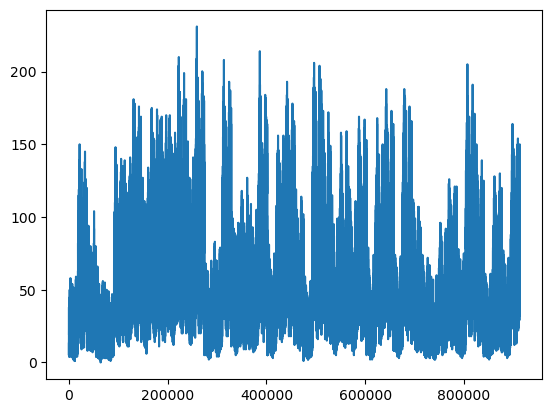

In [16]:
df_s['sales'].plot()

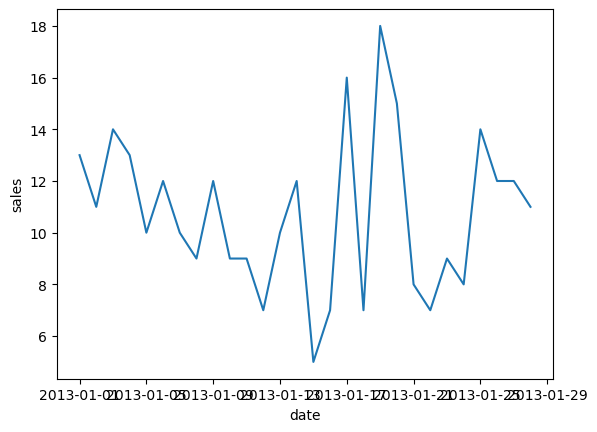

In [17]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])

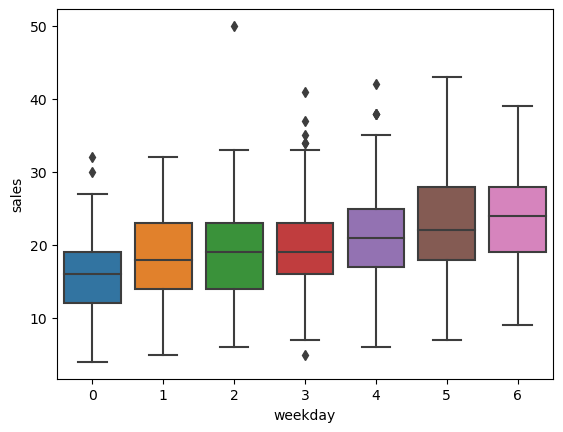

In [18]:
sns.boxplot(x="weekday", y="sales", data=train_df)

In [19]:
'''Definição que exclui os indicadores dos dias da coluna (data_sales)
e cria uma nova tabela com a somas de sales por month'''

def month_years_sales(data, time=['monthly','years']):
    data = data.copy()
    if time == 'monthly':
        data.date = data.date.apply(lambda x: str(x)[:-3])
    else:
        data.date = data.date.apply(lambda x: str(x)[:4])
        
    data = data.groupby('date')['sales'].sum().reset_index()
    data.date = pd.to_datetime(data.date)
    
    return data

In [20]:
df_m = month_years_sales(data_sales, 'monthly')
#df_m.to_csv('./monthly_data.csv')

In [21]:
#Nova tabela mostrando o total de vendas de um determinado mês nas lojas

df_m.head(12)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


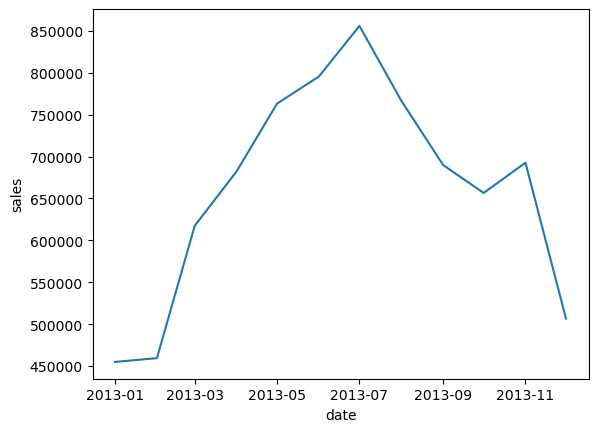

In [22]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=df_m[:12])

In [24]:
df_y = month_years_sales(data_sales, 'years')
df_y

,date,sales
0,2013-01-01,7941243
1,2014-01-01,9135482
2,2015-01-01,9536887
3,2016-01-01,10357160
4,2017-01-01,10733740


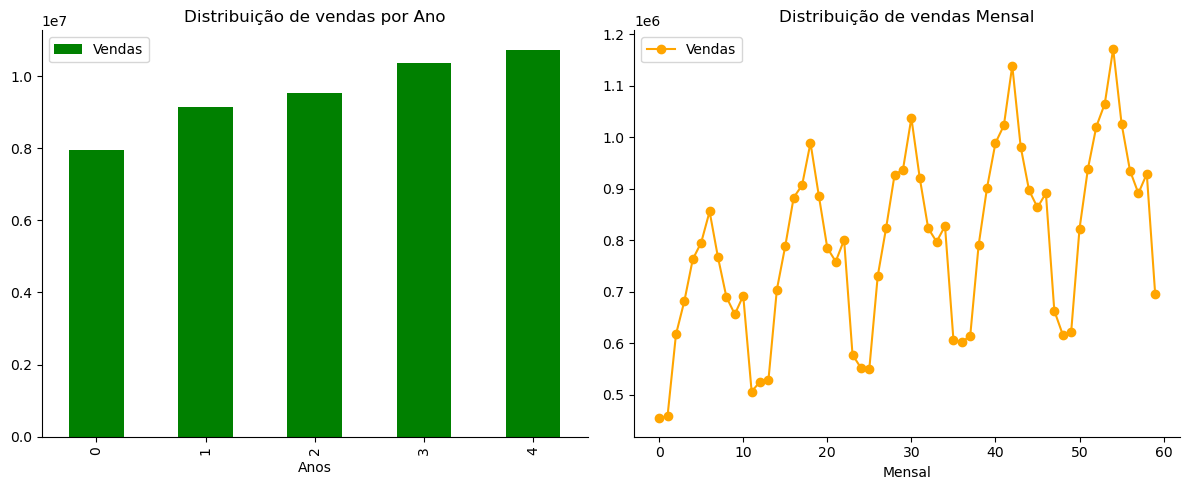

In [48]:
layout = (1,2)

raw = plt.subplot2grid(layout, (0,0))
law = plt.subplot2grid(layout, (0,1))

years = df_y['sales'].plot(kind ='bar', color='green', label='Vendas', ax=raw, figsize=(12,5))
months = df_m['sales'].plot(marker= 'o', color='orange', label='Vendas', ax=law)

years.set(xlabel = 'Anos',title= 'Distribuição de vendas por Ano')
months.set(xlabel = 'Mensal',title= 'Distribuição de vendas Mensal')

sns.despine()
plt.tight_layout()

years.legend()
months.legend()

In [26]:
'''Dados de vendas por loja'''

def sales_per_store(data):
    sales_by_store = data.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(sales_by_store.store, sales_by_store.sales, color='darkblue')
    
    ax.set(xlabel = "Id Loja", ylabel = 'Soma das Vendas', title = 'Total de vendas por loja')
    
    return sales_by_store

,store,sales
0,1,4315603
1,2,6120128
2,3,5435144
3,4,5012639
4,5,3631016
5,6,3627670
6,7,3320009
7,8,5856169
8,9,5025976
9,10,5360158


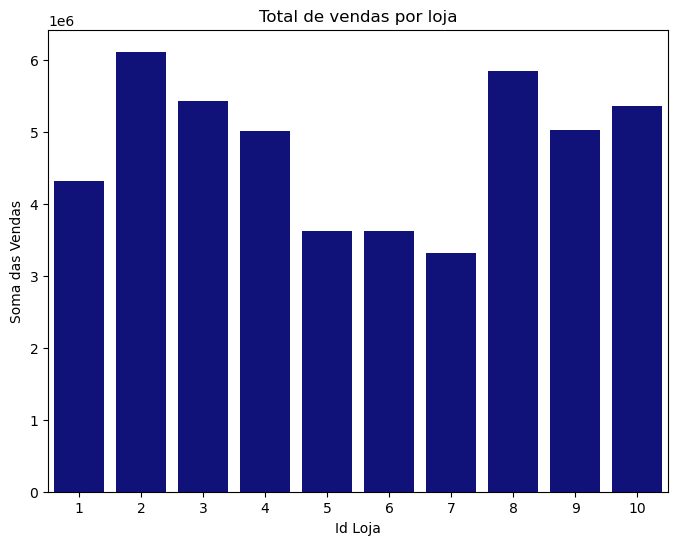

In [27]:
sales_per_store(df_s)

# def abaixo usará Transformação Diferencial como tratamento de Sazonalidade 

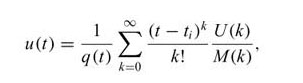

In [43]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize = (15,8))
    sns.lineplot(x_col, y_col, data = data, ax = ax, color = 'darkblue', label='Total de Vendas')
    
    s_mean = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    s_mean.date = pd.to_datetime(s_mean.date, format='%Y')
    sns.lineplot((s_mean.date + datetime.timedelta(6*365/12)), y_col, data=s_mean, ax=ax, color='red', label='Média de Vendas')   
    
    ax.set(xlabel = 'Anos', ylabel = 'Vendas', title = title)

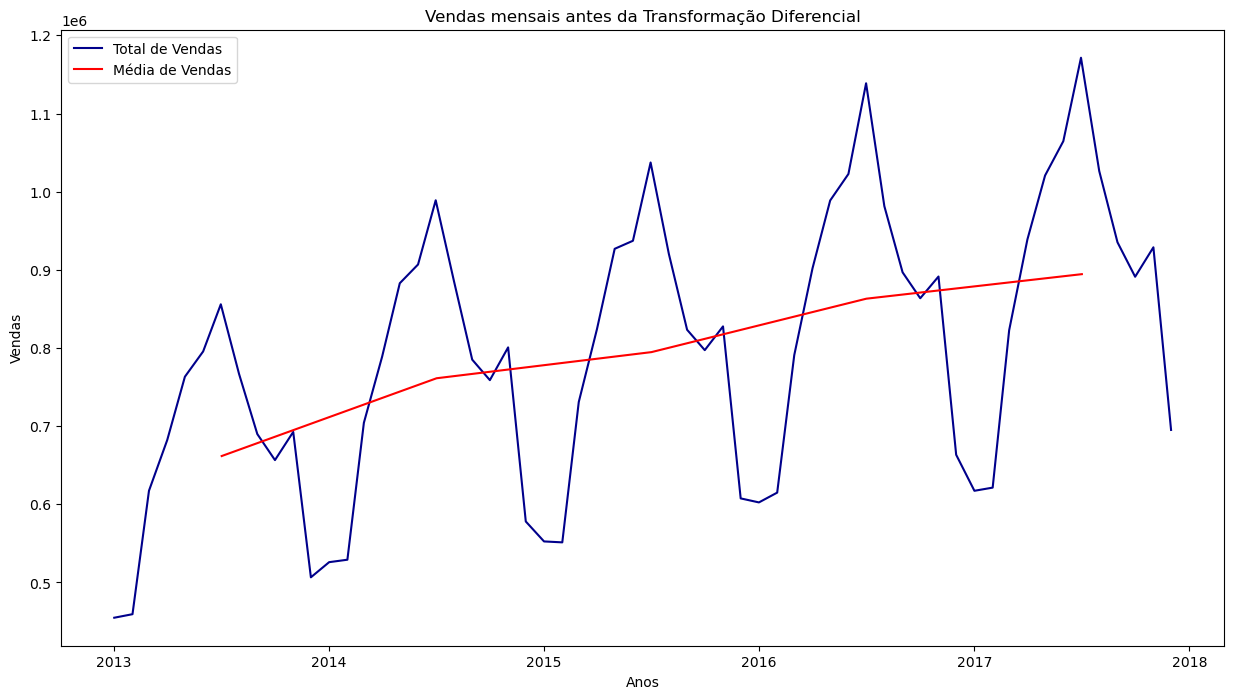

In [29]:
time_plot(df_m, 'date', 'sales', 'Vendas mensais antes da Transformação Diferencial' )

[8.1 Stationarity and differencing](https://otexts.com/fpp2/stationarity.html)

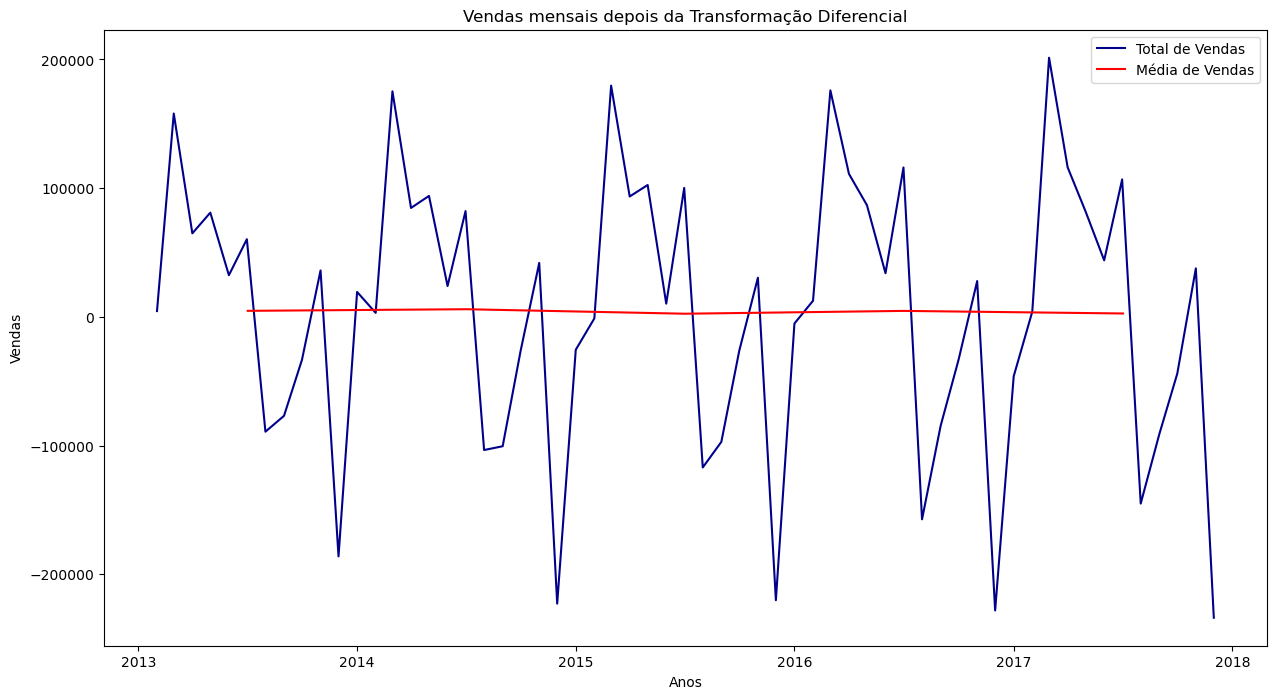

In [30]:
'''Calculo = diferença em vendas mês após mês'''

def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    data.to_csv('./stationary_df.csv')
    return data

stationary_df = get_diff(df_m)
time_plot(stationary_df, 'date', 'sales_diff', 
          'Vendas mensais depois da Transformação Diferencial')

A  equação que representa o cálculo da diferença entre valores consecutivos é a seguinte:

**diff_i = x_i - x_{i-1}**

Nessa equação, diff_i é a diferença entre os valores consecutivos, x_i é o valor da linha atual e x_{i-1} é o valor da linha anterior.

In [37]:
stationary_pd = pd.read_csv('stationary_df.csv')
                            
stationary_pd

,Unnamed: 0,date,sales,sales_diff
0,1,2013-02-01,459417,4513.0
1,2,2013-03-01,617382,157965.0
2,3,2013-04-01,682274,64892.0
3,4,2013-05-01,763242,80968.0
4,5,2013-06-01,795597,32355.0
5,6,2013-07-01,855922,60325.0
6,7,2013-08-01,766761,-89161.0
7,8,2013-09-01,689907,-76854.0
8,9,2013-10-01,656587,-33320.0
9,10,2013-11-01,692643,36056.0


In [39]:
'''Duvida sobre a tabela acima:
    O que deu a entender que Dez/2012
    retornou
    
    Unnamed: 0	date	sales	sales_diff
    0	1	2013-02-01	459417	4513.0
    
    
    ?????
'''

'Duvida sobre a tabela acima:\n    O que deu a entender que Dez/2012\n    retornou\n    \n    Unnamed: 0\tdate\tsales\tsales_diff\n    0\t1\t2013-02-01\t459417\t4513.0\n    \n    \n    ?????\n'

# Modelagem ARIMA

Guia de estudo para aplicações e modelagem de séries temporais com o modelo ARIMA:

***Básico:***

* Entenda o que são séries temporais e por que elas são importantes
* Aprenda a manipular e visualizar séries temporais usando o Pandas
* Entenda os componentes de uma série temporal: tendência, sazonalidade e ruído
* Aprenda a testar a estacionariedade de uma série temporal

***Intermediário:***

* Aprenda a ajustar séries temporais não estacionárias usando diferenciação
* Entenda o que é o modelo ARIMA e como ele pode ser usado para prever séries temporais
* Aprenda a selecionar os melhores parâmetros para o modelo ARIMA usando o processo de seleção de parâmetros
* Aprenda a avaliar o desempenho do modelo ARIMA usando métricas como o RMSE e o MAE
* Aprenda a fazer previsões com o modelo ARIMA usando o Pandas e o statsmodels

***Avançado:***

* Aprenda a tratar séries temporais com sazonalidade não inteira
* Aprenda a tratar séries temporais com tendências não lineares
* Aprenda a fazer previsões a longo prazo com o modelo ARIMA
* Aprenda a integrar o modelo ARIMA com outros modelos de séries temporais, como o modelo SARIMAX
* Aprenda a tratar séries temporais com dados faltantes ou outliers

"Forecasting: Principles and Practice" de Rob J Hyndman e George Athanasopoulos

"Time Series Analysis and Its Applications" de Robert H. Shumway e David S. Stoffer

***CRIAR UM DFT NOVO CONTENDO APENAS UM INDICE DE DATA E HORA E AS COLUNAS DAS VARIAVEIS (DIFF EM VENDAS)***

[Resumo das regras para identificar modelos ARIMA](https://people.duke.edu/~rnau/arimrule.htm)

[statsmodels.graphics.tsaplots.plot_acf](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html)

[Topic 2: Time Series & Autocorrelation
](https://online.stat.psu.edu/stat501/book/export/html/995)

**ACF (Função de Correlação Automática) e (Função de Correlação Automática Parcial)**

  **O que é ACF?**
 
  Por exemplo, o preço das ações de hoje que previmos com base no preço das ações de ontem, o ACF dirá o quanto eles estão correlacionados. .
 
  **O que é PACF?**
 
  Se quisermos calcular a correlação entre hoje e ontem, temos que tomar a correlação de anteontem porque o valor de hoje depende do horário de ontem. Portanto, esta é a razão pela qual usamos o PACF.

   **Modelo PACF-AR**
   
   **Modelo ACF-MA**

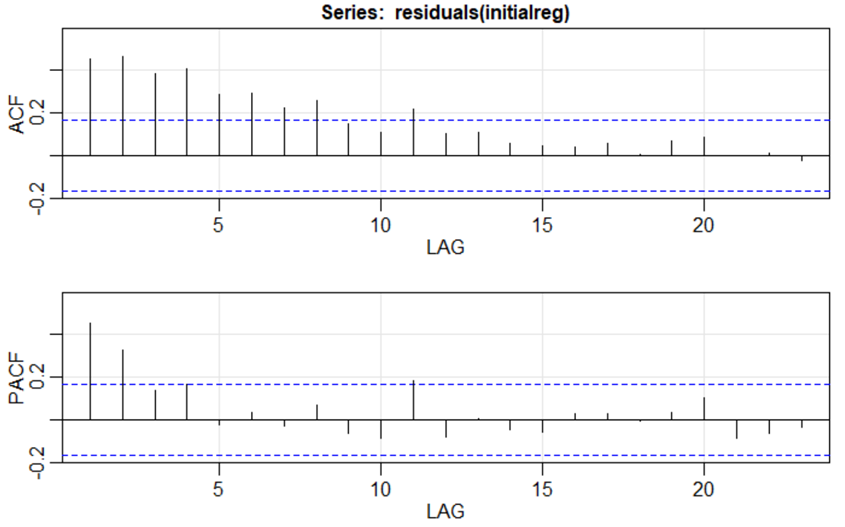

pelas imagens acima podemos observar que, as linhas que cruzam as linhas pontilhadas azuis no PACF e ACF são consideradas como sendo necessários muitos dias para prever o valor de hoje. **Por exemplo, no gráfico PACF acima, que possui apenas três linhas que cruzam as linhas pontilhadas azuis, portanto, os valores dos últimos três dias são necessários para prever o valor de hoje**, da mesma forma o gráfico ACF também, mas para o modelo, não devemos considerar o modelo ACF-MA porque muitas linhas cruzaram a linha limite azul, então isso criará o complexo do modelo. Portanto, devemos selecionar apenas o modelo PACF-AR para prever

In [49]:
'''def build_arima_data(data):
    pegar apenas a data, dropar a columns "sales"
    dropar valores nulos das linhas
    retornar data'''

'def build_arima_data(data):\n    pegar apenas a data, dropar a columns "sales"\n    dropar valores nulos das linhas\n    retornar data'